In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import scipy.io as sio
from scipy.io import loadmat
from PIL import Image

In [ ]:
image_dirA = "/content/drive/MyDrive/SML_PROJECT/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images"
label_dirA = "/content/drive/MyDrive/SML_PROJECT/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/ground_truth"

image_dirB= "/content/drive/MyDrive/SML_PROJECT/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images"
label_dirB= "/content/drive/MyDrive/SML_PROJECT/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/ground_truth"
def create_df(image_dir, label_dir):
    image_files = os.listdir(image_dir)
    image_files.sort()
    label_files = os.listdir(label_dir)
    label_files.sort()

    # Create full paths for image and label files
    image_paths = [os.path.join(image_dir, img) for img in image_files]
    label_paths = [os.path.join(label_dir, lbl) for lbl in label_files]

    dataframe = pd.DataFrame({'image_path': image_paths, 'label_path': label_paths})
    return dataframe
df = create_df(image_dirB,label_dirB)
df.shape

(400, 2)

In [ ]:
print(df["image_path"][5])

/content/drive/MyDrive/SML_PROJECT/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/images/IMG_103.jpg


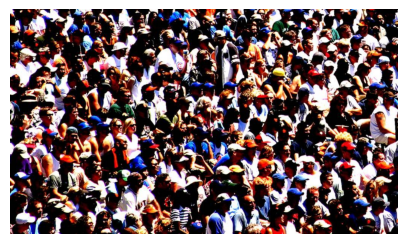

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# File path of the image
image_path = "/content/drive/MyDrive/SML_PROJECT/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/IMG_119.jpg"

# Load the image
image = mpimg.imread(image_path)

# Create a figure and axis to display the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')

# Show the image
plt.show()


In [ ]:
np.mean(df["people_count"])

123.2

# image arrays and count list

In [ ]:
def resize_images_and_store(df, size=(512, 512)):
    image_arrays = []
    error_indices = []

    for index, image_path in enumerate(df['image_path']):
        try:
            # Open image
            img = Image.open(image_path)

            # Convert image to grayscale
            img_gray = img.convert('L')

            # Resize image
            img_resized = img_gray.resize(size)

            # Convert image to array
            img_array = np.array(img_resized)

            # Append to list
            image_arrays.append(img_array)
        except Exception as e:
            # If an error occurs, record the index of the row
            error_indices.append(index)

    return image_arrays, error_indices

image_arrays, error_indices = resize_images_and_store(df)
error_indices


[]

array([[115, 134, 160, ..., 155, 113,  86],
       [135, 168, 221, ..., 232, 175, 139],
       [116, 160, 230, ..., 252, 180, 135],
       ...,
       [131, 145, 166, ..., 124, 125, 126],
       [136, 139, 146, ..., 124, 124, 124],
       [128, 132, 139, ..., 126, 126, 126]], dtype=uint8)
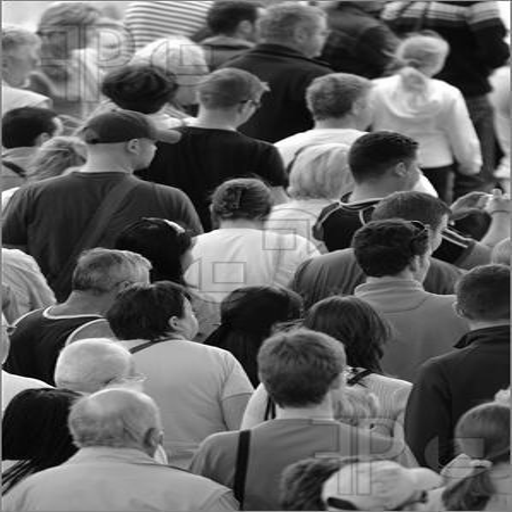

In [ ]:
image_arrays[0]

In [ ]:
people_counts = df["people_count"].tolist()
len(people_counts)

300

# Feature computing

### GLCM features

In [ ]:
#from skimage.feature import greycomatrix, graycoprops
from skimage.feature import graycomatrix as greycomatrix
from skimage.feature import graycoprops as graycoprops

def calculate_glcm_features(image_arrays):
    glcm_features = []

    for img_array in image_arrays:
        # Convert the image array to grayscale if it's not already
        if len(img_array.shape) > 2:
            img_gray = np.dot(img_array[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            img_gray = img_array

        # Convert the grayscale image array to unsigned integer type
        img_gray_uint = img_gray.astype(np.uint8)

        # Calculate GLCM
        glcm = greycomatrix(img_gray_uint, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

        # Calculate GLCM properties
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        # Append GLCM features to the list
        glcm_features.append([contrast, dissimilarity, homogeneity, energy, correlation])

    return glcm_features

glcm_features = calculate_glcm_features(image_arrays)


### LBP features

In [ ]:
from skimage.feature import local_binary_pattern

def calculate_lbp_features(image_arrays, radius=1, n_points=24, method='uniform'):
    lbp_features = []

    for img_array in image_arrays:

        # Calculate LBP
        lbp = local_binary_pattern(img_array, n_points, radius, method)

        # Calculate histogram of LBP
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype(np.float32)
        hist /= hist.sum()  # Normalize the histogram

        # Append LBP features to the list
        lbp_features.append(hist)

    return lbp_features
lbp_features = calculate_lbp_features(image_arrays)


### HOG features

In [ ]:
from skimage.feature import hog
from skimage import exposure

def generate_hog_features(image_list, cell_size=(8, 8), block_size=(3, 3), block_stride=(1, 1), num_bins=9):

    hog_features = []

    for image in image_list:
        # Compute HOG features for each image
        hog_feature_vector, _ = hog(image, orientations=num_bins, pixels_per_cell=cell_size,
                                    cells_per_block=block_size, block_norm='L2-Hys', visualize=True,
                                    feature_vector=True)

        # Normalize HOG features
        hog_feature_vector = exposure.rescale_intensity(hog_feature_vector, in_range=(0, 10))

        hog_features.append(hog_feature_vector)

    return np.array(hog_features)

hog_features = generate_hog_features(image_arrays)


In [ ]:
from sklearn.decomposition import PCA

def generate_hog_features(image_list, cell_size=(8, 8), block_size=(3, 3), block_stride=(1, 1), num_bins=9,
                          n_components=None):
    hog_features = []

    for image in image_list:
        # Compute HOG features for each image
        hog_feature_vector, _ = hog(image, orientations=num_bins, pixels_per_cell=cell_size,
                                    cells_per_block=block_size, block_norm='L2-Hys', visualize=True,
                                    feature_vector=True)

        # Normalize HOG features
        hog_feature_vector = exposure.rescale_intensity(hog_feature_vector, in_range=(0, 10))

        hog_features.append(hog_feature_vector)

    # Convert the list of HOG feature vectors into a 2D array
    hog_features_array = np.array(hog_features)

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        hog_features_array = pca.fit_transform(hog_features_array)

    return hog_features_array

hog_features_pca = generate_hog_features(image_arrays, n_components=280)


# GLCM

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(glcm_features, people_counts, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize Random Forest Regression model with best parameters
rf_glcm_model_best = RandomForestRegressor(**best_params, random_state=42)

# Train the model with the best parameters
rf_glcm_model_best.fit(X_train, y_train)

# Make predictions on the testing set
rf_predictions_best = rf_glcm_model_best.predict(X_test)

# Evaluate the model
rf_mse_best = mean_squared_error(y_test, rf_predictions_best)
print("Random Forest Mean Squared Error with Hyperparameter Tuning:", rf_mse_best)


Random Forest Mean Squared Error with Hyperparameter Tuning: 255078.5110122805


In [ ]:
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR model
}

# Initialize the SVR model
svr_model = SVR(kernel='rbf')

# Initialize GridSearchCV with the SVR model and parameter grid
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVR model with best parameters
svr_glcm_model_best = SVR(kernel='rbf', **best_params)

# Train the model with the best parameters
svr_glcm_model_best.fit(X_train, y_train)

# Make predictions on the testing set
svr_predictions_best = svr_glcm_model_best.predict(X_test)

# Evaluate the model
svr_mse_best = mean_squared_error(y_test, svr_predictions_best)
print("SVR Mean Squared Error with Hyperparameter Tuning:", svr_mse_best)


SVR Mean Squared Error with Hyperparameter Tuning: 302716.50174431625


In [ ]:
import joblib

# Save Random Forest Regression model
joblib.dump(rf_glcm_model_best, 'rf_glcm_best.pkl')

# Save SVR model
joblib.dump(svr_glcm_model_best, 'svr_glcm_best.pkl')


['svr_glcm_best.pkl']

In [ ]:
rf_model = joblib.load('rf_glcm_best.pkl')
svr_model = joblib.load('svr_glcm_best.pkl')

def resize_images_and_store(image_path, size=(512, 512)):
    try:
            # Open image
            img = Image.open(image_path)

            # Convert image to grayscale
            img_gray = img.convert('L')

            # Resize image
            img_resized = img_gray.resize(size)

            # Convert image to array
            img_array = np.array(img_resized)

    except Exception as e:
            print("error reading and processing the image")

    return img_array

def calculate_glcm_features_single(img_array):
    # Convert the image array to grayscale if it's not already
    if len(img_array.shape) > 2:
        img_gray = np.dot(img_array[..., :3], [0.2989, 0.5870, 0.1140])
    else:
        img_gray = img_array

    # Convert the grayscale image array to unsigned integer type
    img_gray_uint = img_gray.astype(np.uint8)

    # Calculate GLCM
    glcm = greycomatrix(img_gray_uint, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

    # Calculate GLCM properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Return GLCM features as a single feature vector
    return [contrast, dissimilarity, homogeneity, energy, correlation]



def predict_people_count(image_path):

    img_array = resize_images_and_store(image_path)
    # Calculate GLCM features
    glcm_features = calculate_glcm_features_single(img_array)

    # Reshape features to fit model input
    glcm_features = np.array(glcm_features).reshape(1, -1)

    # Predict people count using Random Forest Regression model
    rf_prediction = rf_model.predict(glcm_features)

    # Predict people count using SVR model
    svr_prediction = svr_model.predict(glcm_features)

    return rf_prediction, svr_prediction

# Example usage:
num = 158
image_path = df["image_path"][num]
rf_prediction, svr_prediction = predict_people_count(image_path)
print("Random Forest Prediction:", rf_prediction)
print("SVR Prediction:", svr_prediction)
print(df["people_count"][num])


#inference found after trail and error
# if there are more than 400 people then random forest gives less error
# if the actaul people count is less than 400 then SVR gives less error

Random Forest Prediction: [566.81112729]
SVR Prediction: [377.84091092]
403


# GLCM and LBP

In [ ]:
combined_glcm_lbp_features = np.concatenate((glcm_features,lbp_features), axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_glcm_lbp_features, people_counts, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR model
}

# Initialize the SVR model
svr_model = SVR(kernel='rbf')

# Initialize GridSearchCV with the SVR model and parameter grid
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVR model with best parameters
svr_glcm_lbp_model_best = SVR(kernel='rbf', **best_params)

# Train the model with the best parameters
svr_glcm_lbp_model_best.fit(X_train, y_train)

# Make predictions on the testing set
svr_predictions_best = svr_glcm_lbp_model_best.predict(X_test)

# Evaluate the model
svr_mse_best = mean_squared_error(y_test, svr_predictions_best)
print("SVR Mean Squared Error with Hyperparameter Tuning:", svr_mse_best)


SVR Mean Squared Error with Hyperparameter Tuning: 309269.8517187344


In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize Random Forest Regression model with best parameters
rf_glcm_lbp_model_best = RandomForestRegressor(**best_params, random_state=42)

# Train the model with the best parameters
rf_glcm_lbp_model_best.fit(X_train, y_train)

# Make predictions on the testing set
rf_predictions_best = rf_glcm_lbp_model_best.predict(X_test)

# Evaluate the model
rf_mse_best = mean_squared_error(y_test, rf_predictions_best)
print("Random Forest Mean Squared Error with Hyperparameter Tuning:", rf_mse_best)


Random Forest Mean Squared Error with Hyperparameter Tuning: 238244.87252215348


In [ ]:
# Save Random Forest Regression model
joblib.dump(rf_glcm_model_best, 'rf_glcm_lbp_best.pkl')

# Save SVR model
joblib.dump(svr_glcm_model_best, 'svr_glcm_lbp_best.pkl')


['svr_glcm_lbp_best.pkl']

# GCLM LBP HOG

In [ ]:
len(hog_features_pca)

300

In [ ]:
combined_pca_features = []
for i in range(len(glcm_features)):
    combined_features_i = np.concatenate((glcm_features[i], lbp_features[i], hog_features_pca[i]), axis=0)
    combined_pca_features.append(combined_features_i)
combined_features = []
for i in range(len(glcm_features)):
    combined_features_i = np.concatenate((glcm_features[i], lbp_features[i], hog_features[i]), axis=0)
    combined_features.append(combined_features_i)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_pca_features, people_counts, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR model
}

# Initialize the SVR model
svr_model = SVR(kernel='rbf')

# Initialize GridSearchCV with the SVR model and parameter grid
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVR model with best parameters
svr_glcm_lbp_hog_model_best = SVR(kernel='rbf', **best_params)

# Train the model with the best parameters
svr_glcm_lbp_hog_model_best.fit(X_train, y_train)

# Make predictions on the testing set
svr_predictions_best = svr_glcm_lbp_hog_model_best.predict(X_test)

# Evaluate the model
svr_mse_best = mean_squared_error(y_test, svr_predictions_best)
print("SVR Mean Squared Error with Hyperparameter Tuning:", svr_mse_best)


SVR Mean Squared Error with Hyperparameter Tuning: 309656.9791144422


In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize Random Forest Regression model with best parameters
rf_glcm_lbp_model_hog_best = RandomForestRegressor(**best_params, random_state=42)

# Train the model with the best parameters
rf_glcm_lbp_model_hog_best.fit(X_train, y_train)

# Make predictions on the testing set
rf_predictions_best = rf_glcm_lbp_model_hog_best.predict(X_test)

# Evaluate the model
rf_mse_best = mean_squared_error(y_test, rf_predictions_best)
print("Random Forest Mean Squared Error with Hyperparameter Tuning:", rf_mse_best)


In [ ]:
# Save Random Forest Regression model
joblib.dump(rf_glcm_model_best, 'rf_glcm_lbp_hog_best')

# Save SVR model
joblib.dump(svr_glcm_model_best, 'svr_glcm_lbp_hog_best.pkl')


# HOG

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, people_counts, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR model
}

# Initialize the SVR model
svr_model = SVR(kernel='rbf')

# Initialize GridSearchCV with the SVR model and parameter grid
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVR model with best parameters
svr_hog_best = SVR(kernel='rbf', **best_params)

# Train the model with the best parameters
svr_hog_best.fit(X_train, y_train)

# Make predictions on the testing set
svr_predictions_best = svr_hog_best.predict(X_test)

# Evaluate the model
svr_mse_best = mean_squared_error(y_test, svr_predictions_best)
print("SVR Mean Squared Error with Hyperparameter Tuning:", svr_mse_best)

from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize Random Forest Regression model with best parameters
rf_hog_best = RandomForestRegressor(**best_params, random_state=42)

# Train the model with the best parameters
rf_hog_best.fit(X_train, y_train)

# Make predictions on the testing set
rf_predictions_best = rf_hog_best.predict(X_test)

# Evaluate the model
rf_mse_best = mean_squared_error(y_test, rf_predictions_best)
print("Random Forest Mean Squared Error with Hyperparameter Tuning:", rf_mse_best)


# Save Random Forest Regression model
joblib.dump(rf_hog_best, 'rf_hog_best')

# Save SVR model
joblib.dump(svr_hog_best, 'svr_hog_best.pkl')




### HOG_pca

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_pca, people_counts, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR model
}

# Initialize the SVR model
svr_model = SVR(kernel='rbf')

# Initialize GridSearchCV with the SVR model and parameter grid
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVR model with best parameters
svr_hog_pca_best = SVR(kernel='rbf', **best_params)

# Train the model with the best parameters
svr_hog_pca_best.fit(X_train, y_train)

# Make predictions on the testing set
svr_predictions_best = svr_hog_pca_best.predict(X_test)

# Evaluate the model
svr_mse_best = mean_squared_error(y_test, svr_predictions_best)
print("SVR Mean Squared Error with Hyperparameter Tuning:", svr_mse_best)

from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize Random Forest Regression model with best parameters
rf_hog_pca_best = RandomForestRegressor(**best_params, random_state=42)

# Train the model with the best parameters
rf_hog_pca_best.fit(X_train, y_train)

# Make predictions on the testing set
rf_predictions_best = rf_hog_pca_best.predict(X_test)

# Evaluate the model
rf_mse_best = mean_squared_error(y_test, rf_predictions_best)
print("Random Forest Mean Squared Error with Hyperparameter Tuning:", rf_mse_best)


# Save Random Forest Regression model
joblib.dump(rf_hog_pca_best, 'rf_hog_pca_best')

# Save SVR model
joblib.dump(svr_hog_pca_best, 'svr_hog_pca_best.pkl')




# HOG LBP

In [ ]:
combined_glcm_lbp_features = np.concatenate((lbp_features,hog_features), axis=1)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(hog_features_pca, people_counts, test_size=0.2, random_state=42)